In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import geopandas

plt.style.use('ggplot')

In [2]:
%%time

df=pd.read_csv(r'csv_files/Electric_Vehicle_Population_Data.csv')
zips=geopandas.read_file(r"C:\Users\berid\python\geopandas\tl_2019_us_zcta510_zipcodes\tl_2019_us_zcta510.shp")
states=geopandas.read_file(r"C:\Users\berid\python\geopandas\s_22mr22_states\s_22mr22.shp")

CPU times: total: 2min 32s
Wall time: 3min 2s


In [3]:
df['Postal Code']=df['Postal Code'].apply(lambda x:str(int(x)) if str(x)!='nan' else x)

In [4]:
df.sample(2)

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
124396,KNDC3DLC0N,Snohomish,Edmonds,WA,98020,2022,KIA,EV6,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,21.0,211114319,POINT (-122.37689 47.81116),PUGET SOUND ENERGY INC,5.306105e+10
119769,1G1FY6S07M,Snohomish,Edmonds,WA,98026,2021,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,21.0,157645120,POINT (-122.31768 47.87166),PUGET SOUND ENERGY INC,5.306104e+10


In [40]:
g1=df.groupby('Make')['VIN (1-10)'].count().sort_values(ascending=False)

fig=make_subplots(rows=1,cols=2,specs=[[{'type':'pie'}, {"type": "bar"}]])
trace1=go.Pie(labels=g1[g1.values>2000].index,values=g1[g1.values>2000].values,hole=0,
              pull=[i*0.05 for i in range(len(g1[g1.values>2000].index))])
trace2=go.Bar(x=g1[g1.values<=2000].index,y=g1[g1.values<2000].values,
              text=(g1[g1.values<2000].values/g1.values.sum()*100).round(2))
fig.add_trace(trace1,1,1),fig.add_trace(trace2,1,2)
fig.update_traces(trace1, marker=dict(colors=px.colors.sequential.RdBu),row=1,col=1)
fig.update_traces(trace2, marker=dict(color=g1[g1.values<2000].values,colorscale='RdBu'),row=1,col=2)
fig.update_layout(title=dict(text='SHARE OF ELECTRIC VEHICLES BY MANUFACTURER',font_family='Arial Black'),height=800,width=1600)
fig.show()

In [6]:
df['Long']=df['Vehicle Location'].apply(lambda x:str(x).split('(')[-1].split(' ')[0].strip()).astype(float)
df['Lat']=df['Vehicle Location'].apply(lambda x:str(x).split(' ')[-1].replace(')','').strip()).astype(float)

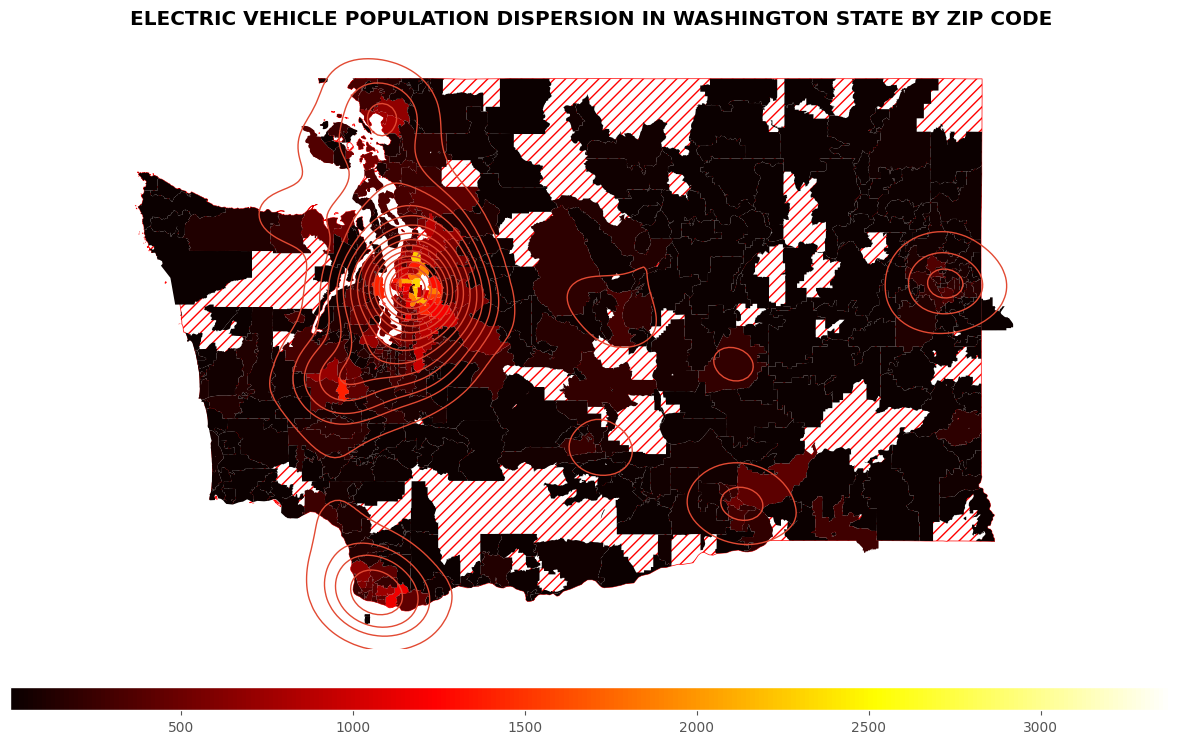

In [36]:
g2=df.groupby('Postal Code')['VIN (1-10)'].count().reset_index()
g2=g2.merge(zips[['GEOID10','geometry']],left_on='Postal Code',right_on='GEOID10')
g2=geopandas.GeoDataFrame(g2)

fig,ax=plt.subplots(figsize=(15,10))
states[states['STATE']=='WA'].plot(ax=ax,color='white',ec='red',hatch="///")
g2.plot(ax=ax,column='VIN (1-10)',cmap='hot',legend=True,legend_kwds={'orientation':'horizontal','aspect':50,'pad':0.05})
sns.kdeplot(df[df['State']=='WA'].sample(5*10**3),x='Long',y='Lat',ax=ax,linewidths=1,levels=15)
ax.set_title('ELECTRIC VEHICLE POPULATION DISPERSION IN WASHINGTON STATE BY ZIP CODE',fontweight='bold')
ax.set_xlim(-125.2,-116)
ax.set_ylim(45.3,49.3)
ax.axis('off')
plt.show()

In [8]:
g3=df.value_counts('Model Year',sort=False)

fig=px.bar(x=g3.index,y=g3.values,text=g3.values,color=g3.values,color_continuous_scale='hot')
fig.update_layout(title=dict(text='NUMBER OF ELECTRIC VEHICLES IN WASHINGTON STATE BY MANUFACTURING YEAR',font_family='Arial Black'))
fig.update_xaxes(title_text='Year',tickmode='array',ticktext=[str(i) for i in g3.index],tickfont_size=10)
fig.update_yaxes(title_text='Number of Electric Vehicles')
fig.update_traces(textposition='outside', textfont_size=8)
fig.show()